# Tensorflow Tutorials

In [1]:
import numpy as np
import tensorflow as tf
from time import time
from IPython.display import Image
import math

In [2]:
import bokeh.plotting as bk
from bokeh.io import push_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
import warnings
bk.output_notebook()

Loading BokehJS ...

In [3]:
warnings.filterwarnings('ignore')

## Install TensorFlow

It is possible to install it either with provided binary packages or directly from source. However to compile TensorFlow you need to install Bazel, Google own build tool. We suggest as a starting point ot use the binary package. 

**<font color='red'>REMARK</font>**: to use GPU capabilities you need to first install [CUDA Toolkit](http://www.nvidia.com/object/cuda_home_new.html) and [cuDNN](https://developer.nvidia.com/cudnn) if you have a cuda enabled device. (Tensorflow now supports Cuda Toolkit 8.0 and cuDNN 5.1) 

There are few options for binary installation:
* [pip](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html#pip-installation) 
* [virtualenv](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html#virtualenv-installation)
* [anaconda](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html#anaconda-installation)
* [docker](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html#docker-installation)

Using a virtual environment, such as with virtualenv and Anaconda, is safer for learning and experimenting. Eventually you will need to use pip, please select the python package **with GPU support**, based on your preferred interpreter (python 2.7, python 3.4 or python 3.5 are all supported) and follow instructions. Through this notebook we will use python 3.5. If you don't have a Cuda GPU it is still possible to use TensorFlow, choose the installation with CPU only support.

To use this notebook please install anaconda then follow these instructions:
*  `conda update anaconda` 
* `conda env create -f tensorflow.yml` 
* `conda activate tensorflow`
* `export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/gpu/tensorflow_gpu-1.0.1-cp35-cp35m-linux_x86_64.whl`
* `pip install --ignore-installed --upgrade $TF_BINARY_URL`
* `mkdir -p ~/.ipython/kernels`
* `mv ~/.local/share/jupyter/kernels/python3 ~/.ipython/kernels/tfkernel`
* `vim ~/.ipython/kernels/tfkernel/kernel.json` and change `display_name` of the kernel to, for example, TensorFlow
* change the kernel of this notebook to **TensorFlow**: `Kernel -> Change kernel -> TensorFlow`

**<font color='red'>WARNING</font>**: this library natively supports only Linux and Mac OS. The easiest way to use it under Windows operating system, without compiling it from source, is to use a doker image.

## 1 Tensorflow Basics

### 1.1 Overview

TensorFlow represent computations as **graphs**. Nodes in the graph are called **ops** (operations). An op takes zero or more **Tensors** and produces zero or more Tensors as output. A Tensor is a multidimensional array with a specified type. The graph is a description of a computation, in order to actually execute the computation a graph must be launched in a **session**. A session exectue a specific graph on one of the available **devices** (that can be either CPUs or GPUs).

### 1.2 Building the Graph

TensorFlow programs are usually structured into a construction phase, that assembles a graph, and an execution phase that uses a session to execute ops in the graph.

For example, it is possible to represent and train a neural network in the construction phase, and then repeatedly execute a set of training ops in the graph in the execution phase.

It is possibile to build a graph by starting with nodes that do not need any input, such as constant nodes. Then it is possible to use the output of the constant node as input to other operations. TensorFlow uses a default graph to which operations are added. It is sufficient for most operations but it is also possible to manage multiple graphs with the `Graph` class.

In [4]:
a = tf.constant([[4.]])
b = tf.constant([[3.]])
product = tf.matmul(a, b)

The code creates three nodes: two constant and an operation (multiplication) that takes two inputs (the two constants) and produces an output (product). To actually procude an output is is necessary to run the graph in a session

### 1.3 Launching a Session

Without argument the Session construct uses the default graph. It is necessary to close a session once it is open, otherwise use `with ... as  ...` statement.

In [5]:
with tf.Session() as sess:
    result = sess.run([product])
    print(result)

[array([[ 12.]], dtype=float32)]


Tensorflow translates the graph into executable operations and it distributes the computation automatically on available resources. It uses the available **GPU** for as many operations as possible.

It is possible to use a **specific device** for a session with `with tf.device("/gpu:1"):` statement. For example previous command execute the graph on the second GPU of the machine. Try to change the string and execute the code on CPU (or another GPU of your machine)

In [6]:
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        result = sess.run([product])
        print(result)

[array([[ 12.]], dtype=float32)]


In an interactive environment like IPython or Jupyter it could be useful to interleave graph construction and run operations, you can use `InteractiveSession`. The only difference with a regular `Session` is that an `InteractiveSession` installs itself as the default session on construction. The methods `Tensor.eval()` and `Operation.run()` will use that session to run ops.

### 1.4 Tensor Variables

TensorFlow uses **Tensors** to represents all data. Only tensors are passed between ops in the graph. Tensors are an n-dimensional arrays, and, in TensorFlow, are described with rank, shape and type. The rank its the number of dimensions (different from matrix rank), the shape is the number of elements for each dimension and the type is the data type assigned to the tensor.  

**Variables** are used to maintain state accross executions of the graph. In this example `state` is initialized to zero and updated each time `update` is run. When using variables, they must be initialized after launching the graph, that is after creating a session. In order to initialize the variables it is necessary to add an init operation that must be run *before* all other operations

In [7]:
state = tf.Variable(0, name="counter")

one = tf.constant(1)
new_value = tf.add(state, one)
update = tf.assign(state, new_value)

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    print('state: ' + str(sess.run(state)))
    for _ in range(3):
        sess.run(update)
        print('state: ' + str(sess.run(state)))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
state: 0
state: 1
state: 2
state: 3


Here `assign` is part of the computational graph as `add` and other operators. They won't produce an effect until `run()` executes the expression. Variables are typically used to represent parameters of a model, for example in neural network they are used to store the weights matrix, that it is updated at every execution of the graph. It is possible to **fetch** more than one variable by passing them simultaneously to the run() command (`session.run([var1, var2])`).

So far we have covered how to store values in constant and use variable to update their values. TensorFlow provides also a method to pass a value to the variables with a **feed** mechanism. A feed replace the value of an operation with a value. The typical case is to use **placeholder** to feed the operation with values.

In [8]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = tf.multiply(input1, input2)

with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[7.], input2:[2.]}))

[array([ 14.], dtype=float32)]


A variable declaered as placeholder expects a feed and generate an error if it is not supplied

## 2 Classification with a Multi Layer Perceptron

### 2.1 Neural Network Basics

A brain neuron has a structure formed by a cell body, an axon were it sends messages to other neuron and dendritic tree were it receives messages from other neuron. A neuron generates outgoing charge (throughout the axon) whenever enough charge has been received (activation).

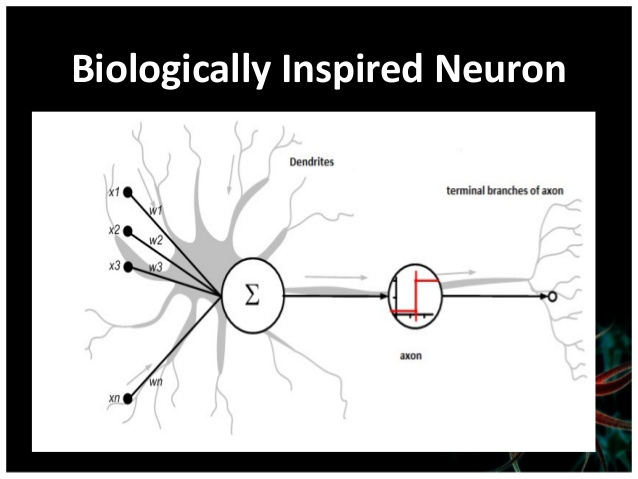

In [9]:
Image('images/neuron.jpeg', width=400, height=400)

What is a neural network? 

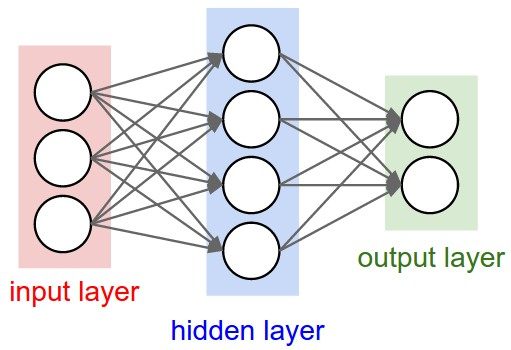

In [10]:
Image('images/neural_net.jpeg')

In practice they learn how to approximate functions. For example, for a classifier, it maps an input to a category `y = f(x)`. They are called networks because they combine many function together. The graph depicts how the function are composed in layers. Each function in the most basic form combines the input with a series of weights. Think about the most basic linear regression `y = wx+b`. `w` is called the **weights matrix** (if we are in higher dimensions) and `b` is the **bias vector**. If we think about the neurons of the brain are activated by a stimuli, it is not suprising that an **activation function** can be applyed to the linear combination of weights, biases and inputs. 

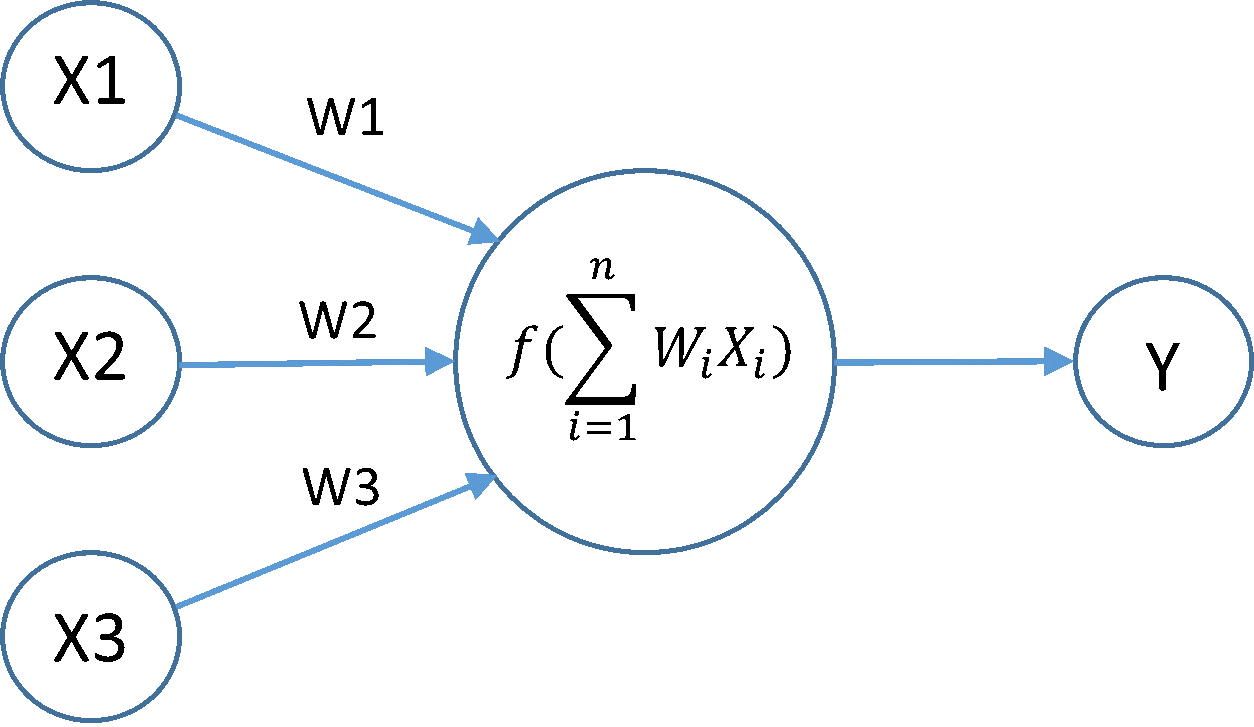

In [11]:
Image('images/Simple Neural Network.png',  width=500, height=500)

The result of all linear combinations and activation functions gives the results, and to quantify how the network is performing we define a **cost function** C.

Learning in this contex reduces to find the best weights that allows the neural network to approximate the function, that is to have a small cost function. The algorithm that performs this learning is called **backpropagation**. At the heart of backpropagation is an expression for the partial derivative ∂C/∂w of the cost function C with respect to any weight w (or bias b) in the network. The expression tells us how quickly the cost changes when we change the weights and biases. 

The **learning algorithm** tells us how much and how often we change the weights.

### 2.2 The Dataset

We will learn to classify MNIST handwritten digit images into their correct label (0-9). MNIST is a standard dataset hosted on [Yann LeCun's website](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html). The digits have been size-normalized and centered in a fixed-size image.

The importance of classical datasets is twofold. First they are good for people who want to try machine learning techniques while spending minimal efforts on preprocessing and formatting data. Second they are useful for comparing machine learning algorithms, since we know well how they work on these datasets.

Each image is 28 pixels by 28 pixels, representing an handwritten number between 0 to 9.

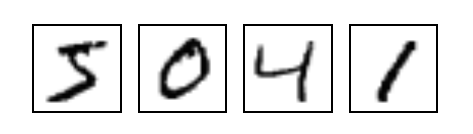

In [12]:
Image('images/mnist1.png')

We can interpret this as a big array of numbers:

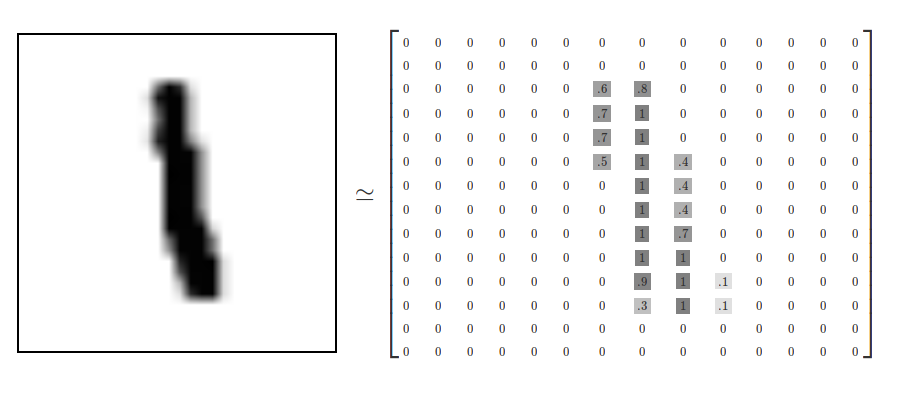

In [13]:
Image('images/mnist2.png',  width=500, height=500)

Since each image has 28 by 28 pixels, we get a 28x28 array. We can flatten each array into a 28∗28=784 dimensional vector. Each component of the vector is a value between zero and one describing the intensity of the pixel. Thus, we generally think of MNIST as being a collection of 784-dimensional vectors. Flattening the image may throw away information about the structure and it surely does. There are methods that look directly at the 2D image but will be covered in later tutorials.

Now, we load the data and we see how it is organized.

In [14]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The dataset is split into three parts, one for training, one for testingand one for validation. Each dataset is an n-dimensional array with shape [number of examples, 784]. Each example is an image with associated a corresponding label, a number between 0 - 9 that represents the digit depicted in the image.

In [15]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

In [16]:
print('train examples: ', mnist.train.num_examples)
print('test examples: ', mnist.test.num_examples)
print('validation examples: ', mnist.validation.num_examples)

train examples:  55000
test examples:  10000
validation examples:  5000


In order to classify the digits we will use an output layer with 10 units, one for each digits. For this reason our labels are encoded as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case the
n-th digit will be represented as a vector which is 1 in the n-th dimension. For example, 3 would be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Consequently, mnist.train.labels is a [55000, 10] array of floats.

In [17]:
print(mnist.train.labels[0])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


### 2.3 The Network

Now we will build the network step-by-step, we will discuss its (simple) architecture and how to built it with TensorFlow.

The standard way to use TensorFlow is to create the graph first and then run it in a session. A more flexible way to perform a computation is using InteractiveSession. It allows to interleave operations of construction with ones that run the graph, and that is good feature for a notebook!

In [18]:
sess = tf.InteractiveSession()

Our simple MLP looks like this: input -> hidden layer -> output classification

Defining a `tf.placeholder` with `None` as its first dimension indicates that the first dimension, corresponding to the batch size, can be any size. These placeholder will contain input images and labels and will be fed to the program during the training phase.

In [19]:
image_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_PIXELS])
label_placeholder = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])

In order to provide a dictionary when feeding the placeholder, we use a small helper function.

In [20]:
def get_feed_dict(batch, place_1, place_2):
    return {place_1: batch[0], place_2: batch[1]}

The hidden layer has a number of units that can be specified with the parameter `hidden1_units` and it computes a transformation of the linear combination of inputs, weights and biases. There are a lot of transformation available in TensorFlow, one of the most widely used is the Rectified **Linear Unit or ReLU**. Its function is f(x) = max(0, x).

The weight matrix is initialized to random values, while the bias vector is initialized to a costant (small) value; it is also good practice to initialize weights of a ReLU with a slightly positive initial bias to avoid "dead neurons". A reasonable-sounding idea then might be to set all the initial weights to zero, which we expect to be the "best guess" in expectation. This turns out to be a mistake, because if every neuron in the network computes the same output, then they will also all compute the same gradients during backpropagation and undergo the exact same parameter updates. In other words, there is no source of asymmetry between neurons if their weights are initialized to be the same. It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights

In [21]:
hidden1_units = 20

with tf.name_scope('hidden1'):
    weights = tf.Variable(
        tf.truncated_normal([IMAGE_PIXELS, hidden1_units], 
                            stddev=0.1 / math.sqrt(float(IMAGE_PIXELS))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden1_units]),
                         name='biases')

    hidden1 = tf.nn.relu(tf.matmul(image_placeholder, weights) + biases)

Note the use of `tf.name_scope` to define a prefix to the variables. 

The last stage compute a **softmax** transformation of the hidden layer. The softmax is a generalization of the logistic function, it is used to calculate the probability associated to each class and it is usefull in multiclass classification problems. A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities. Here a class is one of the 10 possibile digits.

In [22]:
with tf.name_scope('softmax_linear'):
    weights = tf.Variable(
        tf.truncated_normal([hidden1_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden1_units))),
        name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                         name='biases')
    logits = tf.matmul(hidden1, weights) + biases

After we constructed the graph, we need to initialize the variable in the session.

In [23]:
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Next we define the cost function, cross entropy in this case. Cross-entropy gives us a way to express how different two probability distributions are. The more different the distributions p and q are, the more the cross-entropy of p with respect to q will be bigger than the entropy of p. Similarly, the more different p is from q, the more the cross-entropy of q with respect to p will be bigger than the entropy of q. If the distributions are the same, this difference will be zero. As the difference grows, it will get bigger.

Now it is possible to use TensorFlow automatic differentiation to find the gradients of the cost with respect to each variable. For this example we use basic steepest gradient descent as optimizer.  **Gradient Descent** is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost. This *little bit* is the **learning rate** and it is multiplied by the negative of the gradient. For this examples the learning rate is fixed at 0.05. Actually we are using **Stochastic Gradient Descent**. Stochastic means that we are not using all the data to perform a single update of the weights but we are using a subsample at a time. This subsample is called **mini batch** and it is random. Each time we exahaust the training set we can recompute another subsample and so on. Each iteration (that is each time the algorithm consumes all the dataset) is an epoch. At each epoch the function gets better.

In [24]:
learning_rate = 0.05

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=label_placeholder,
                                                        name='xentropy')

loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

To evaluate the model we first compute the position of the maximum entry in both predicted and real output. This corresponds to the class to which the example belongs. Then we compare the two vector to determine what fraction of the predicted output is correct.

In [25]:
correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(logits),1), 
                              tf.argmax(label_placeholder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

The next code displays the training loss, the validation loss and test loss function. To actually see the graph, first start the algorithm. The plots will updates dinamically.

In [26]:
train_accuracy_vector = []
valid_accuracy_vector = []
test_accuracy_vector = []
cost_vector = []
input_vector = []

s_train = ColumnDataSource(data=dict(x=input_vector, y=train_accuracy_vector))
s_valid = ColumnDataSource(data=dict(x=input_vector, y=valid_accuracy_vector))
s_test = ColumnDataSource(data=dict(x=input_vector, y=test_accuracy_vector))
s_cost = ColumnDataSource(data=dict(x=input_vector, y=cost_vector))

fig1 = bk.figure(plot_width=500, 
                plot_height=300,
                x_axis_label='Epochs',
                y_axis_label='Precision (%)')

fig1.line('x', 'y', source=s_train, legend='training')
fig1.line('x', 'y', source=s_valid, color='red', legend='validation')
fig1.line('x', 'y', source=s_test, color='green', legend='test')

fig2 = bk.figure(plot_width=500, 
                plot_height=300,
                x_axis_label='Epochs',
                y_axis_label='Cost')

fig2.line('x', 'y', source=s_cost)

p = gridplot([[fig1], [fig2]])

In [27]:
def update_c(x_vec, y_vec):
    s_cost.data['x'] = x_vec
    s_cost.data['y'] = y_vec
    push_notebook()
    
def update(x_vec, t_vec, v_vec, e_vec):
    s_train.data['x'] = x_vec
    s_valid.data['x'] = x_vec
    s_test.data['x'] = x_vec
    s_train.data['y'] = t_vec
    s_valid.data['y'] = v_vec
    s_test.data['y'] = e_vec
    push_notebook()

In [28]:
ha1 = bk.show(p, notebook_handle=True)

Ok, now we are ready to launch the training:

In [29]:
epochs = 25
batch_size = 64
train_batches = mnist.train.num_examples // batch_size

for epoch in range(epochs+1):
    train_costs = []
    train_accuracy = []
    for i in range(train_batches):
        feed_dict = get_feed_dict(mnist.train.next_batch(batch_size), 
                                  image_placeholder, 
                                  label_placeholder)
        _, loss_value = sess.run([train_op, loss], 
                                 feed_dict= feed_dict)
        train_accuracy.append(accuracy.eval(feed_dict=feed_dict))
        train_costs.append(loss_value)

    train_accuracy_vector.append(np.mean(train_accuracy) * 100)
    cost_vector.append(np.mean(train_costs))
    update_c(range(epoch), cost_vector)
     
    valid_accuracy_vector.append(accuracy.eval(feed_dict={image_placeholder: mnist.validation.images, 
                                                          label_placeholder: mnist.validation.labels}) * 100)
    test_accuracy_vector.append(accuracy.eval(feed_dict={image_placeholder: mnist.test.images, 
                                                         label_placeholder: mnist.test.labels}) * 100)
    
    update(range(epoch), train_accuracy_vector, valid_accuracy_vector, test_accuracy_vector)

**REMARK** Epochs are calculated directly by the mnist object. Whenver the number of batches requested is greather than the number of examples it automatically updates the number of epochs. The object shuffles also the training set for better learning.

In [30]:
print(accuracy.eval(feed_dict={image_placeholder: mnist.test.images, 
                               label_placeholder: mnist.test.labels}))

0.961


## 3 TensorFlow contrib.learn

The module **learn** in the contrib section of the repository of TensorFlow was formerly known as skflow and it is meant to provide ease of use and modularity, for beginners and for integrating TensorFlow models in existing code. It has an interface similar to scikit-learn and it is possible to create a Neural Network with few line of code.

In [31]:
from tensorflow.contrib import learn
tf.logging.set_verbosity(tf.logging.ERROR)

In [32]:
classifier = learn.DNNClassifier(hidden_units=[hidden1_units],
                                 n_classes=NUM_CLASSES,
                                 feature_columns=learn.infer_real_valued_columns_from_input(mnist.train.images.astype(np.float32)),
                                 optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05)) 
                                 # model_dir="logdir/")

With just one line of code we are able to create the same neural network that took us many line of code to compute, and with just one line we can fit it.

In [33]:
classifier.fit(mnist.train.images, 
               np.argmax(mnist.train.labels, axis=1).astype(np.int64), 
               batch_size=batch_size, 
               steps=3000) 

DNNClassifier(params={'input_layer_min_slice_size': None, 'hidden_units': [20], 'feature_columns': (_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None),), 'gradient_clip_norm': None, 'optimizer': <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7fed7807dc50>, 'dropout': None, 'activation_fn': <function relu at 0x7fedf23b0158>, 'embedding_lr_multipliers': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7fed7807df98>})

The accuracy is similar to the example above.

In [34]:
accuracy_score = classifier.evaluate(x=mnist.test.images.astype(np.float32), 
                                     y=np.argmax(mnist.test.labels, axis=1).astype(np.int64))["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

Accuracy: 0.934200


Learn has many models, for example it is possible to create a linear classification model or even a Random Forest! It is also possible to create an highly customized model by providing a model function to an `Estimator` object. However if the model is highly complex maybe it is best to use plain TensorFlow.

## 4 Deeper Network

The performance of the simple MLP is pretty good, but what if we want to improve it? Increasing the number of layers does not improve the accuracy, but why? This is known as the vanishing or exploding gradient problems. That is, the learning procedure based on gradients is unstable if we have many layers, resulting in the last layers to learn slowly. For this reason in order to train deeper network we must use another kind of network, the **Convolutional Neural Network**. In practice to avoid the vanishing gradient problem we use a specialized network with fewer parameters, that takes advantage of spatial locality of the images.

The following code defines the usual placeholder for the input examples and associated labels, as well as two helper functions to construct weight variables.

In [35]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [36]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Convolutional neural networks use three basic ideas: local receptive fields, shared weights, and pooling. Let's look at each of these ideas in turn. 

Local receptive fields: In the fully-connected layers shown earlier, the inputs were depicted as a vertical line of neurons. In a convolutional net, it'll help to think instead of the inputs as a 28×28 square of neurons, whose values correspond to the 28×28 pixel intensities we're using as inputs:

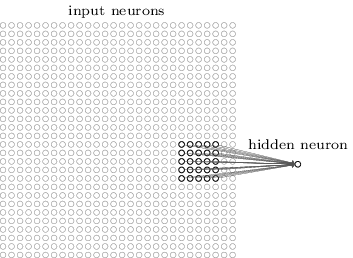

In [37]:
Image('images/receptive.png')

We will connect the input pixels to a layer of hidden neurons. But we don't connect every input pixel to every hidden neuron. Instead, we only make connections in small, localized regions of the input image.

To be more precise, each neuron in the first hidden layer will be connected to a small region of the input neurons, say, for example, a 5×5 region, corresponding to 25 input pixels. That region in the input image is called the **local receptive field** for the hidden neuron. I've shown the local receptive field being moved by one pixel at a time. In fact, sometimes a different stride length is used. For instance, we might move the local receptive field 2 pixels to the right (or down), in which case we'd say a stride length of 2 is used. 

Each hidden neuron has a bias and 5×5 weights connected to its local receptive field. What I did not yet mention is that we're going to use the same weights and bias for each of the 24×24 hidden neurons. This means that all the neurons in the first hidden layer detect exactly the same feature just at different locations in the input image. They **Share weights and biases**. For this reason, we sometimes call the map from the input layer to the hidden layer a **feature map**. We call the weights defining the feature map the shared weights. And we call the bias defining the feature map in this way the shared bias. The shared weights and bias are often said to define a kernel or filter.

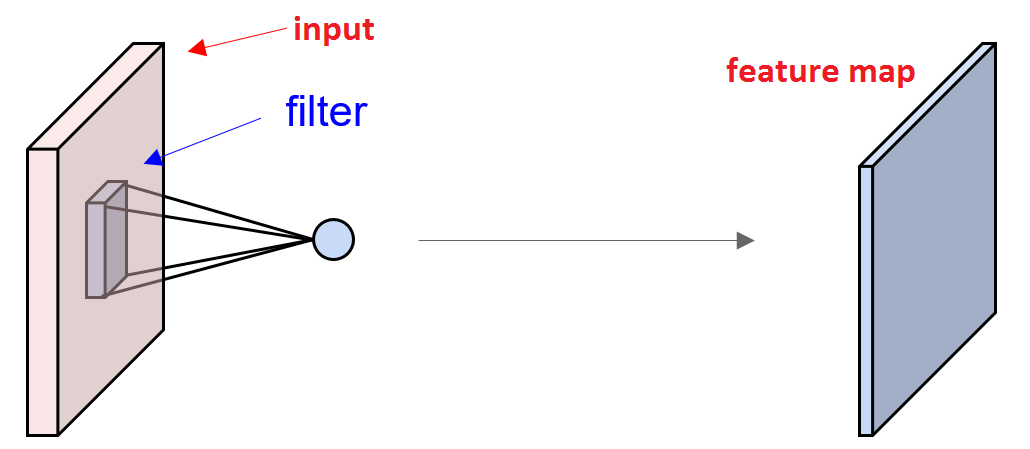

In [38]:
 Image('images/feature_map.png', width=700, height=700)

**Pooling layers**: In addition to the convolutional layers just described, convolutional neural networks also contain pooling layers. Pooling layers are usually used immediately after convolutional layers. What the pooling layers do is simplify the information in the output from the convolutional layer. Pool layers perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x14x32].

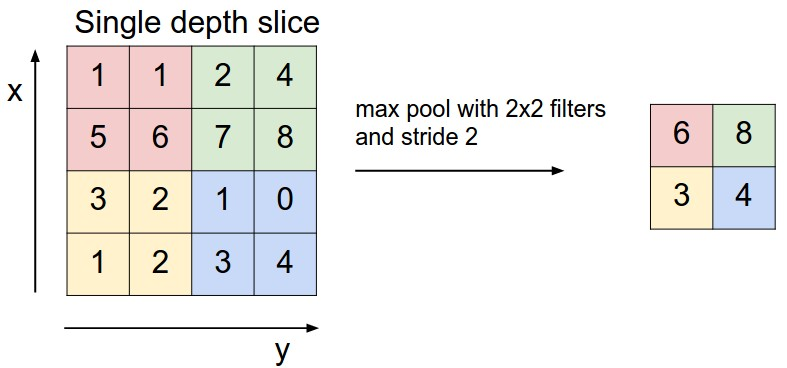

In [39]:
Image('images/maxpool.jpeg', width=600, height=600)

In [40]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


Reshape of the input so it resemble a 2D image.

In [41]:
x_image = tf.reshape(x, [-1,28,28,1])

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel. 

A big advantage of sharing weights and biases is that it greatly reduces the number of parameters involved in a convolutional network. For each feature map we need 25=5×5 shared weights, plus a single shared bias. So each feature map requires 26 parameters. If we have 32 feature maps that's a total of 32×26=832 parameters defining the convolutional layer. By comparison, suppose we had a fully connected first layer, with 784=28×28 input neurons, and a relatively modest 32 hidden neurons, as we used in many of the examples earlier in the book. That's a total of 784×32 weights, plus an extra 32 biases, for a total of 25,088 parameters. In other words, the fully-connected layer would have more than 30 times as many parameters as the convolutional layer.

In [42]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [43]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

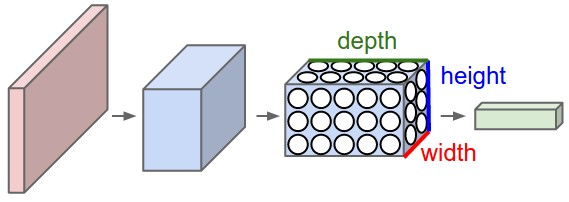

In [44]:
Image('images/cnn.jpeg')

In [45]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Last but not least, a fully connected layer that is able to combine previous layers

In [46]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

One thing to mention is regularization we applied dropout to prevent overfitting. 

In [47]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Last stage compute probability and assign to each example a class.

In [48]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [49]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
    batch = mnist.train.next_batch(64)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], 
                                                  y_: batch[1], 
                                                  keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.09375
step 1000, training accuracy 1
step 2000, training accuracy 0.984375
step 3000, training accuracy 1
step 4000, training accuracy 0.96875
step 5000, training accuracy 1
step 6000, training accuracy 0.984375
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 0.984375
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1


In [50]:
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, 
                                                  y_: mnist.test.labels, 
                                                  keep_prob: 1.0}))

test accuracy 0.9921


## 5 Additional resources

* [TensorFlow playground](http://playground.tensorflow.org/)
* [TensorFlow examples](https://github.com/aymericdamien/TensorFlow-Examples)
* [Colah's Blog](http://colah.github.io/)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.